In [2]:
import os 
from pathlib import Path
import json

import pandas as pd
import numpy as np

from utils.paths import VOL_EXPERIMENTS_DIR 



In [3]:
SEEDS = [31102003, 26021999, 31031963, 21061965,
         20031031, 19990226, 19630331, 19650621,
         11020033, 60219992, 10319633, 10619652,
         13204658, 59061527]

In [75]:

names = [
        "exp_205_mlp_100_muon_seeds",
        "exp_209_mlp_100_adam_seeds",
        "exp_204_cnn_100_muon_seeds",
        'exp_206_cnn_100_adam_seeds',
        'exp_212_transformer_100_muon_seeds',
        'exp_214_transformer_100_adam_seeds',
        'exp_211_lstm_100_adam_seeds',
        'exp_208_lstm_100_muon_seeds'
]


lookup_table = {
    "exp_205_mlp_100_muon_seeds" : "exp_035_mlp_100_muon_lr",
    "exp_209_mlp_100_adam_seeds" : 'exp_038_mlp_100_adam_lr',
    "exp_204_cnn_100_muon_seeds" : 'exp_169_cnn_100_muon_icml_3',
    'exp_206_cnn_100_adam_seeds' : 'exp_037_cnn_100_adam_lr',
    'exp_212_transformer_100_muon_seeds' : 'exp_180_transformer_100_muon',
    'exp_214_transformer_100_adam_seeds' : 'exp_179_transformer_100_adam_lr',
    'exp_211_lstm_100_adam_seeds' : 'exp_039_lstm_100_adam_lr',
    'exp_208_lstm_100_muon_seeds' : 'exp_036_lstm_100_muon_lr'
}


from scipy.stats import t

alpha = 0.05
df = 14

t_crit = t.ppf(1 - alpha/2, df)


res = dict()

for name in names:
    oos_nmse = []
    seen_seeds = set()

    trials = os.listdir(Path(VOL_EXPERIMENTS_DIR) / name)
    trials = sorted(trials)
    trials = [t for t in trials if 'visuals' not in t][-14:]
    
    #trials = trials 
    trials = trials + ['trial_search_best']

    for trial in trials:
        if 'visual' in trial:
            continue
        cfg_path = Path(VOL_EXPERIMENTS_DIR) / name / trial / 'config_snapshot.json'
        try:
            with open(cfg_path, 'r') as f:
                data = json.load(f)

            seed = data['cfg']['experiment']['random_state']
    
            if seed in seen_seeds:
                print(f'seed {seed} already seen')
            else:
                seen_seeds.add(seed)
        except:
            pass
            #print(f'Error for file {cfg_path}')

        if trial != 'trial_search_best':
            analysis_df_path = Path(VOL_EXPERIMENTS_DIR) / name / trial / 'analysis' / 'fold_avg_metrics.csv' 

        else:
            pass
            other_name = lookup_table[name]
            print(f'other name: {other_name}')
            analysis_df_path = Path(VOL_EXPERIMENTS_DIR) / other_name / trial / 'analysis' / 'fold_avg_metrics.csv' 
        try:
            df = pd.read_csv(analysis_df_path)
            nmse = df[df['Model']=='NN'].loc[:, 'Test MSE'].values
            nmse = float(nmse[0])
        except FileNotFoundError:
            print(f'File {analysis_df_path} not found')
            #continue
        oos_nmse.append(nmse)
    
    mu = np.mean(oos_nmse)
    std = np.std(oos_nmse, ddof=1)
    n = len(oos_nmse)
    me = t_crit * (std / np.sqrt(n))
    confint = (round(float(mu-me), 4), round(float(mu+me), 4))

    res[name] = [round(mu, 4), round(std, 4), confint, n, len(seen_seeds), oos_nmse]


other name: exp_035_mlp_100_muon_lr
other name: exp_038_mlp_100_adam_lr
other name: exp_169_cnn_100_muon_icml_3
other name: exp_037_cnn_100_adam_lr
other name: exp_180_transformer_100_muon
other name: exp_179_transformer_100_adam_lr
other name: exp_039_lstm_100_adam_lr
other name: exp_036_lstm_100_muon_lr


2.1447866879169273


In [76]:
df = pd.DataFrame(res).T
df.columns = ['mean', 'sample_std', 'confint_t_14','n_trials', 'n_seeds', 'observations']
df.to_csv('./confint.csv')
df

,mean,sample_std,confint_t_14,n_trials,n_seeds,observations
exp_205_mlp_100_muon_seeds,0.577,0.0003,"(0.5769, 0.5772)",15,14,"[0.5770262863916901, 0.5771568250537412, 0.576..."
exp_209_mlp_100_adam_seeds,0.5751,0.0011,"(0.5744, 0.5757)",15,14,"[0.5756386058982135, 0.5760483680189532, 0.574..."
exp_204_cnn_100_muon_seeds,0.5762,0.0017,"(0.5752, 0.5772)",15,14,"[0.5762246550555568, 0.5750053426840842, 0.575..."
exp_206_cnn_100_adam_seeds,0.5746,0.0015,"(0.5738, 0.5754)",15,14,"[0.5735664230554051, 0.5756116467750546, 0.575..."
exp_212_transformer_100_muon_seeds,0.5768,0.0033,"(0.5749, 0.5786)",15,14,"[0.5749036597636143, 0.5741881179792111, 0.574..."
exp_214_transformer_100_adam_seeds,0.5751,0.0014,"(0.5743, 0.5759)",15,14,"[0.5740615296223175, 0.5746419474890548, 0.575..."
exp_211_lstm_100_adam_seeds,0.5768,0.0024,"(0.5755, 0.5782)",15,14,"[0.5751516996184397, 0.5842661055875948, 0.574..."
exp_208_lstm_100_muon_seeds,0.5785,0.0018,"(0.5775, 0.5794)",15,14,"[0.5773899973756754, 0.5817783061158344, 0.576..."


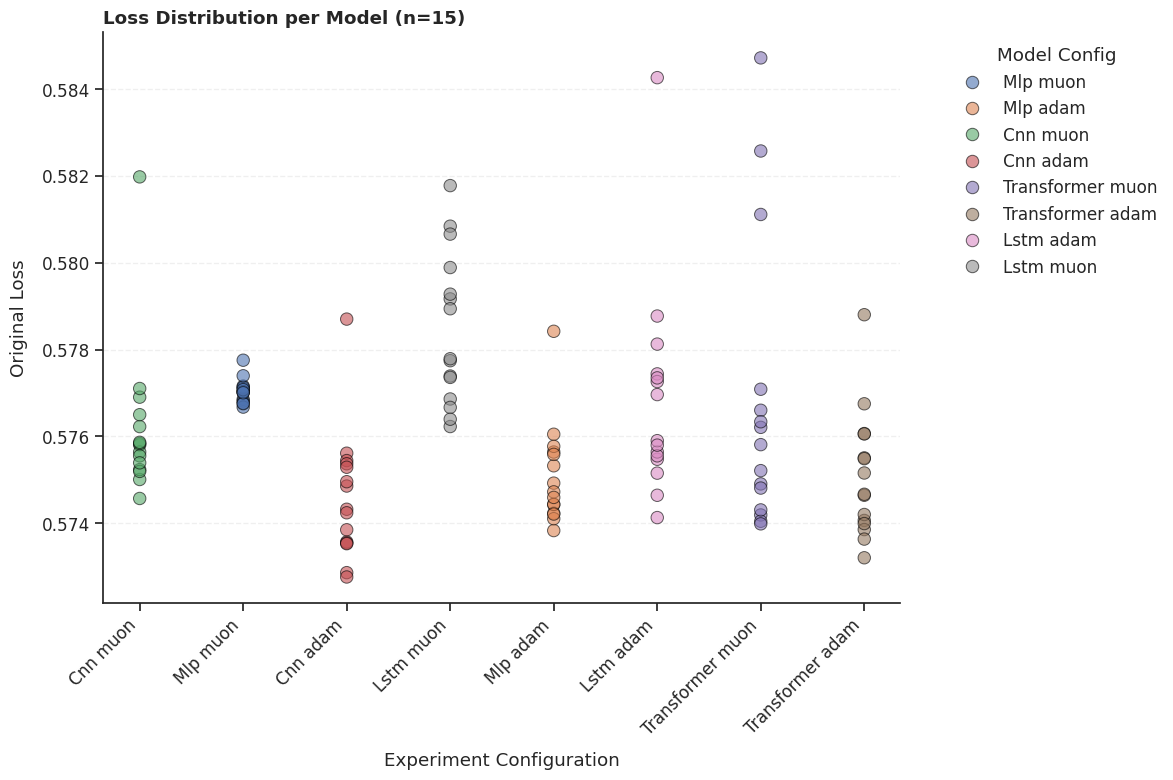

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.inference_utils import format_legend_name

# 1. Transform observations to long-form
df_long = df.reset_index().explode('observations')
df_long['observations'] = df_long['observations'].astype(float)
df_long = df_long.rename(columns={'index': 'Experiment', 'observations': 'Loss'})

# 2. Setup mapping and formatted names
# We sort to ensure index 1 matches the first element in clean_names
unique_exps = sorted(df_long['Experiment'].unique())
mapping = {name: i + 1 for i, name in enumerate(unique_exps)}

# Use your format_legend_name list
# Ensure clean_names is ordered the same as unique_exps
clean_names = [format_legend_name(n) for n in unique_exps]
clean_names = [n.replace(' SEEDS', '').replace(' 100', '').capitalize() for n in clean_names]

# 3. Create the specialized DataFrame
df_scatter = pd.DataFrame({
    'x_idx': df_long['Experiment'].map(mapping),
    'loss': df_long['Loss'],
    'clean_label': df_long['Experiment'].map(dict(zip(unique_exps, clean_names)))
})

# 4. Plotting
plt.figure(figsize=(12, 8), dpi=100)
sns.set_style("ticks")

# Plotting with hue assigned to the clean labels
sns.scatterplot(
    data=df_scatter,
    x='x_idx',
    y='loss',
    hue='clean_label',
    alpha=0.6,
    s=80,
    edgecolor='black'
)

# 5. Legend and Tick Refinement
# Assign clean names to the x-ticks
plt.xticks(ticks=range(1, 9), labels=clean_names, rotation=45, ha='right')

# Move legend outside the plot area since clean names can be long
plt.legend(title='Model Config', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.xlabel('Experiment Configuration', labelpad=10)
plt.ylabel('Original Loss', labelpad=10)
plt.title('Loss Distribution per Model (n=15)', loc='left', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()

plt.tight_layout()
plt.show()

/tmp/ipykernel_3372853/3239797315.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(
/tmp/ipykernel_3372853/3239797315.py:28: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipykernel_3372853/3239797315.py:28: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


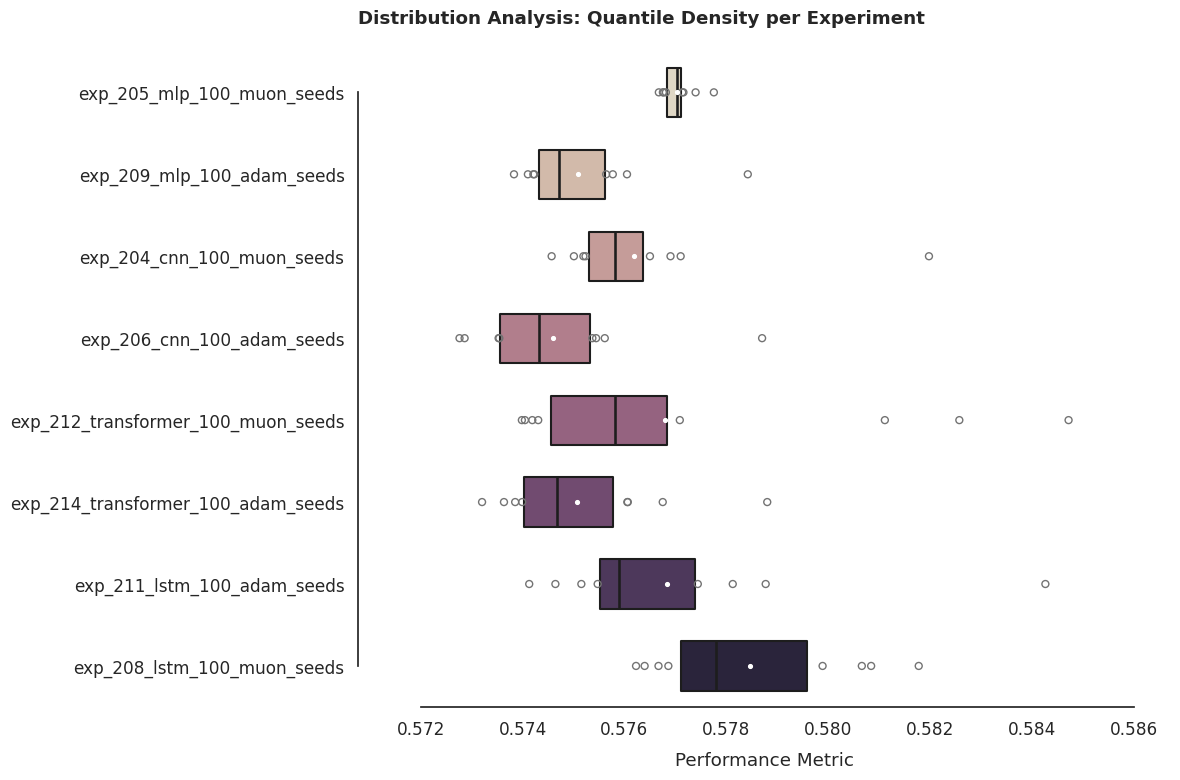

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare data (Long-form)
df_plot = df.reset_index().explode('observations')
df_plot['observations'] = df_plot['observations'].astype(float)
df_plot = df_plot.rename(columns={'index': 'Experiment', 'observations': 'Score'})

# 2. Setup Aesthetic
sns.set_theme(style="white", font_scale=1.1)
plt.figure(figsize=(12, 8), dpi=100)

# 3. The Boxenplot
# This shows the distribution density via 'letter-value' boxes
sns.boxenplot(
    data=df_plot, 
    y='Experiment', 
    x='Score', 
    palette="ch:s=-.2,r=.6", # Sophisticated sequential palette
    width=0.6,
    linewidth=1.5,
    outlier_prop=0.05
)

# 4. Overlay Mean Points
# Since boxenplots focus on medians, we overlay the mean as a white dot
sns.pointplot(
    data=df_plot, 
    y='Experiment', 
    x='Score', 
    estimator='mean',
    color="white", 
    markers="o", 
    scale=0.5,
    join=False,
    errorbar=None
)

# 5. Focus & Refinement
plt.xlim(df_plot['Score'].min() - 0.002, df_plot['Score'].max() + 0.002)
plt.title('Distribution Analysis: Quantile Density per Experiment', loc='left', fontweight='bold', pad=20)
plt.xlabel('Performance Metric', labelpad=10)
plt.ylabel('')
sns.despine(trim=True)

plt.tight_layout()
plt.show()

In [50]:
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.stats import ttest_rel, ttest_ind

# --- input: your existing summary df, indexed by experiment name ---
# df_summary columns: ["mean","sample_std","n_trials","n_seeds","observations"]
# Make sure df_summary["observations"] are Python lists/arrays of floats.

def holm_adjust(pvals):
    """Holm step-down adjusted p-values (FWER control)."""
    pvals = np.asarray(pvals, dtype=float)
    m = len(pvals)
    order = np.argsort(pvals)
    adj = np.empty(m, dtype=float)

    prev = 0.0
    for k, i in enumerate(order):
        # Holm multiplier for k-th smallest p
        a = (m - k) * pvals[i]
        a = min(1.0, a)
        # enforce monotonicity of adjusted p-values
        a = max(prev, a)
        adj[i] = a
        prev = a
    return adj

def pairwise_tests_from_observations(df_summary, paired=True):
    # sanity: coerce observations to np arrays
    obs = {idx: np.asarray(df_summary.loc[idx, "observations"], dtype=float)
           for idx in df_summary.index}

    # optional: check equal lengths
    lens = {k: len(v) for k, v in obs.items()}
    if len(set(lens.values())) != 1:
        raise ValueError(f"Not all observation arrays have same length: {lens}")

    results = []
    for a, b in combinations(df_summary.index, 2):
        xa, xb = obs[a], obs[b]

        # choose test
        if paired:
            tstat, pval = ttest_rel(xa, xb, nan_policy="omit")
            test_name = "paired_t"
            # effect size for paired: mean(diff)/std(diff)
            d = (xa - xb)
            eff = d.mean() / d.std(ddof=1)
            delta = d.mean()  # mean difference (a - b)
        else:
            tstat, pval = ttest_ind(xa, xb, equal_var=False, nan_policy="omit")
            test_name = "welch_t"
            # effect size (approx): Cohen's d with pooled std (rough; Welch has no single pooled var)
            eff = (xa.mean() - xb.mean()) / np.sqrt((xa.var(ddof=1) + xb.var(ddof=1)) / 2)
            delta = xa.mean() - xb.mean()

        results.append({
            "A": a, "B": b,
            "test": test_name,
            "mean_A": xa.mean(), "mean_B": xb.mean(),
            "delta_A_minus_B": delta,
            "t": tstat, "p": pval,
            "effect_size_d": eff,
            "n": len(xa)
        })

    res = pd.DataFrame(results)
    res["p_holm"] = holm_adjust(res["p"].values)
    return res.sort_values(["p_holm", "p", "delta_A_minus_B"], ascending=[True, True, False]).reset_index(drop=True)

# --- run ---
#res_paired = pairwise_tests_from_observations(df, paired=True)
res_welch  = pairwise_tests_from_observations(df, paired=False)

res_welch

,A,B,test,mean_A,mean_B,delta_A_minus_B,t,p,effect_size_d,n,p_holm
0,exp_206_cnn_100_adam_seeds,exp_208_lstm_100_muon_seeds,welch_t,0.574592,0.578466,-0.003874,-6.540109,5.022235e-07,-2.388110,15,0.000014
1,exp_209_mlp_100_adam_seeds,exp_208_lstm_100_muon_seeds,welch_t,0.575083,0.578466,-0.003383,-6.236842,1.876984e-06,-2.277373,15,0.000051
2,exp_214_transformer_100_adam_seeds,exp_208_lstm_100_muon_seeds,welch_t,0.575070,0.578466,-0.003395,-5.768429,3.896420e-06,-2.106333,15,0.000101
3,exp_205_mlp_100_muon_seeds,exp_209_mlp_100_adam_seeds,welch_t,0.577037,0.575083,0.001954,6.414426,9.718877e-06,2.342217,15,0.000243
4,exp_205_mlp_100_muon_seeds,exp_206_cnn_100_adam_seeds,welch_t,0.577037,0.574592,0.002445,6.324424,1.379663e-05,2.309353,15,0.000331
5,exp_205_mlp_100_muon_seeds,exp_214_transformer_100_adam_seeds,welch_t,0.577037,0.575070,0.001967,5.163431,1.157445e-04,1.885418,15,0.002662
6,exp_204_cnn_100_muon_seeds,exp_208_lstm_100_muon_seeds,welch_t,0.576186,0.578466,-0.002280,-3.563497,1.336059e-03,-1.301205,15,0.029393
7,exp_206_cnn_100_adam_seeds,exp_211_lstm_100_adam_seeds,welch_t,0.574592,0.577069,-0.002478,-3.250544,3.614956e-03,-1.186931,15,0.075914
8,exp_205_mlp_100_muon_seeds,exp_208_lstm_100_muon_seeds,welch_t,0.577037,0.578466,-0.001429,-3.107729,7.359340e-03,-1.134782,15,0.147187
9,exp_204_cnn_100_muon_seeds,exp_206_cnn_100_adam_seeds,welch_t,0.576186,0.574592,0.001594,2.703745,1.167237e-02,0.987268,15,0.221775


In [3]:
import json

#
names = [
        'exp_204_cnn_100_muon_seeds',
        'exp_206_cnn_100_adam_seeds',
]

for name in names:
    name  = names[1]

    seen_seeds = set()


    trials = os.listdir(Path(VOL_EXPERIMENTS_DIR) / name)
    trials = sorted(trials)
    trials = [t for t in trials if 'visuals' not in t][-14:]
    #trials = sorted(trials[-14:])
    #print(len(trials))
    print(trials)

    for trial in trials:
        print(trial)
        if 'visual' in trial:
            continue
        cfg_path = Path(VOL_EXPERIMENTS_DIR) / name / trial / 'config_snapshot.json'
        with open(cfg_path, 'r') as f:
            data = json.load(f)

        seed = data['cfg']['experiment']['random_state']
        if seed in seen_seeds:
            print(f'seed {seed} already seen')
        else:
            seen_seeds.add(seed)
        print(data['cfg']['experiment'].get('merge_train_val', None), seed)
        
    missing = [s for s in SEEDS if s not in seen_seeds]
    print(missing)

['trial_20260127_001339', 'trial_20260127_001933', 'trial_20260127_002529', 'trial_20260127_003123', 'trial_20260127_003718', 'trial_20260127_004312', 'trial_20260127_004906', 'trial_20260127_005501', 'trial_20260127_010057', 'trial_20260127_010652', 'trial_20260127_011246', 'trial_20260127_011841', 'trial_20260127_012436', 'trial_20260127_103421']
trial_20260127_001339
True 31102003
trial_20260127_001933
True 26021999
trial_20260127_002529
True 31031963
trial_20260127_003123
True 21061965
trial_20260127_003718
True 20031031
trial_20260127_004312
True 19990226
trial_20260127_004906
True 19630331
trial_20260127_005501
True 19650621
trial_20260127_010057
True 11020033
trial_20260127_010652
True 60219992
trial_20260127_011246
True 10319633
trial_20260127_011841
True 10619652
trial_20260127_012436
True 13204658
trial_20260127_103421
True 59061527


NameError: name 'SEEDS' is not defined

In [27]:
experiments = [
    "exp_035_mlp_100_muon_lr",
    "exp_038_mlp_100_adam_lr",
    "exp_043_mlp_100_sgd",
    "exp_169_cnn_100_muon_icml_3",
    "exp_037_cnn_100_adam_lr",
    "exp_041_cnn_100_sgd",
    "exp_180_transformer_100_muon",
    "exp_179_transformer_100_adam_lr",
    "exp_181_transformer_100_sgd",
    "exp_039_lstm_100_adam_lr",
    "exp_036_lstm_100_muon_lr",
    "exp_042_lstm_100_sgd"
]


import os
import json
from pathlib import Path

# Assuming VOL_EXPERIMENTS_DIR is defined
results = {}

for name in experiments:
    exp_path = Path(VOL_EXPERIMENTS_DIR) / name
    if not exp_path.exists():
        continue
        
    # Filter out 'visuals' and non-directory items
    trials = [t for t in sorted(os.listdir(exp_path)) if 'visual' not in t]
    
    # 1. Find the target LR from 'trial_search_best'
    target_lr = None
    if 'trial_search_best' in trials:
        ref_cfg = exp_path / 'trial_search_best' / 'config_snapshot.json'
        if ref_cfg.exists():
            with open(ref_cfg, 'r') as f:
                ref_data = json.load(f)
                target_lr = ref_data['cfg']


    # 2. Match other trials against the target_lr
    if target_lr is not None:
        for trial in trials:
            if trial == 'trial_search_best':
                continue
                
            cfg_path = exp_path / trial / 'config_snapshot.json'
            if cfg_path.exists():
                with open(cfg_path, 'r') as f:
                    data = json.load(f)
                    current_lr = data['cfg']
                    
                    if current_lr == target_lr:
                        results[name] = [trial, 'trial_search_best']
                        break  # Found the match, move to next experiment

print(results)


{'exp_035_mlp_100_muon_lr': ['trial_000_011', 'trial_search_best'], 'exp_038_mlp_100_adam_lr': ['trial_000_011', 'trial_search_best'], 'exp_043_mlp_100_sgd': ['trial_000_012', 'trial_search_best'], 'exp_169_cnn_100_muon_icml_3': ['trial_000_035', 'trial_search_best'], 'exp_037_cnn_100_adam_lr': ['trial_000_011', 'trial_search_best'], 'exp_041_cnn_100_sgd': ['trial_000_010', 'trial_search_best'], 'exp_180_transformer_100_muon': ['trial_000_003', 'trial_search_best'], 'exp_179_transformer_100_adam_lr': ['trial_000_012', 'trial_search_best'], 'exp_181_transformer_100_sgd': ['trial_000_010', 'trial_search_best'], 'exp_039_lstm_100_adam_lr': ['trial_000_011', 'trial_search_best'], 'exp_036_lstm_100_muon_lr': ['trial_000_011', 'trial_search_best'], 'exp_042_lstm_100_sgd': ['trial_000_010', 'trial_search_best']}


In [32]:

for name in results.keys():
    
    nmse_trial = 0
    for trial in results[name]:
        analysis_df_path = Path(VOL_EXPERIMENTS_DIR) / name / trial / 'analysis' / 'fold_avg_metrics.csv' 

        df = pd.read_csv(analysis_df_path)
        nmse = df[df['Model']=='NN'].loc[:, 'Test MSE'].values
        nmse = float(nmse[0])
        
        if nmse_trial != 0:
            ratio = nmse_trial/nmse
            print(f'{name} | {ratio:.4f}')

        nmse_trial = nmse

    

exp_035_mlp_100_muon_lr | 0.9996
exp_038_mlp_100_adam_lr | 1.0024
exp_043_mlp_100_sgd | 1.0017
exp_169_cnn_100_muon_icml_3 | 0.9907
exp_037_cnn_100_adam_lr | 1.0025
exp_041_cnn_100_sgd | 1.0339
exp_180_transformer_100_muon | 0.9988
exp_179_transformer_100_adam_lr | 0.9982
exp_181_transformer_100_sgd | 0.8035
exp_039_lstm_100_adam_lr | 1.0010
exp_036_lstm_100_muon_lr | 0.9937
exp_042_lstm_100_sgd | 1.0706


In [33]:
501 % 100

1

**Compare data points and begin of eoss regime**

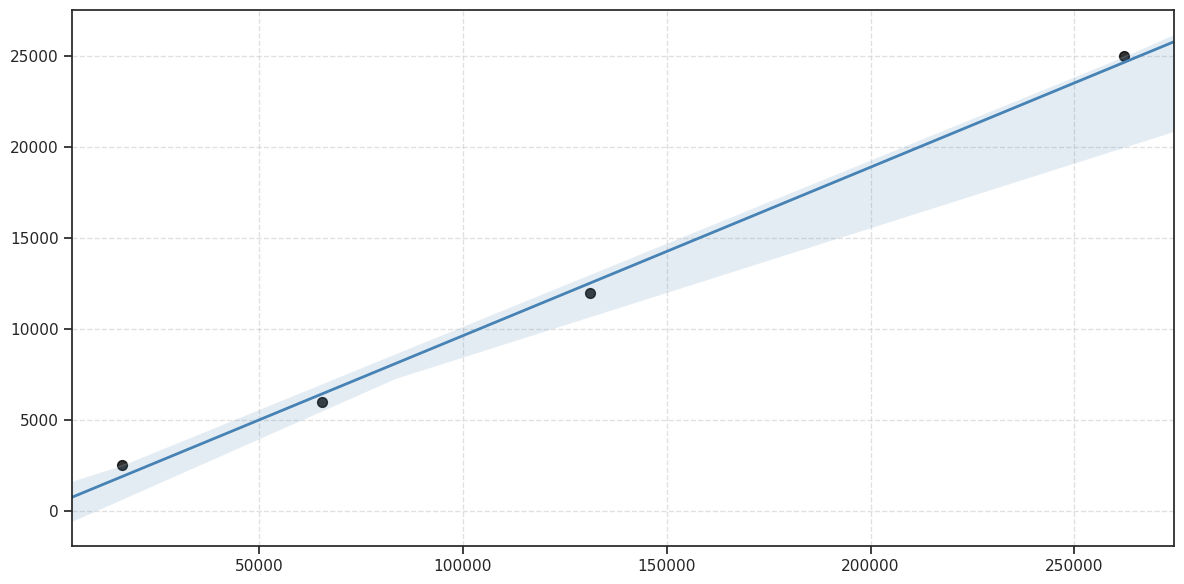

np.float64(0.9983801473529281)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("dark")


# Data
x = np.array([16384, 65536, 131072, 262144])
y = np.array([2500, 6000, 12000, 25000])

plt.figure(figsize=(12, 6))
sns.set_theme(style="ticks")

# Corrected regplot syntax
sns.regplot(x=x, y=y, ci=95, truncate=False, 
            scatter_kws={"color": "black", "s": 50}, 
            line_kws={"color": "steelblue", "lw": 2})

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

np.corrcoef(x,y)[0][1]


**Diebold Mariano**
